In [1]:
import os
# Numpy for vectorization
import numpy as np
# Tensorflow for ML
import tensorflow as tf
# Pandas for file reading/ visualize data
import pandas as pd
# Seaborn as the great data visualizer
import seaborn as sns
#Matplot to visualize data, also Seaborn and pandas do this
import matplotlib.pyplot as plt
# Inline to show images in jupyter notebook
%matplotlib inline

# Set number of columns to show in the notebook
pd.set_option('display.max_columns', 600)
# Set number of rows to show in the notebook
pd.set_option('display.max_rows', 50)
# Make the graphs a bit prettier
pd.set_option('display.mpl_style', 'default') 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipython-5.2.2-py3.6.egg/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Grab the shakespeare data
allData = pd.read_csv('../Data/Shakespeare_data.csv', sep=',')

In [3]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
Data-line             111396 non-null int64
Play                  111396 non-null object
Player Line number    111393 non-null float64
Act-Scene-Line        105153 non-null object
Player                111389 non-null object
Player-Line           111396 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [4]:
allData.columns
allData.values

array([[1, 'Henry IV', nan, nan, nan, 'ACT I'],
       [2, 'Henry IV', nan, nan, nan, 'SCENE I. London. The palace.'],
       [3, 'Henry IV', nan, nan, nan,
        'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others'],
       ..., 
       [111394, 'A Winters Tale', 38.0, '5.3.182', 'LEONTES',
        "Perform'd in this wide gap of time since first"],
       [111395, 'A Winters Tale', 38.0, '5.3.183', 'LEONTES',
        "We were dissever'd: hastily lead away."],
       [111396, 'A Winters Tale', 38.0, nan, 'LEONTES', 'Exeunt']], dtype=object)

In [5]:
allData.head()

,Data-line,Play,Player Line number,Act-Scene-Line,Player,Player-Line
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [20]:
# Take only the columns we need, this will be a data frame.
linesAndNumbers = allData[["Player Line number", "Player-Line"]]
amountLines = allData[["Player Line number"]]
lines = allData[["Player-Line"]].astype(str)
print('length of both arrays: ', len(amountLines), ' ', len(linesAndNumbers),' ',  len(lines))

length of both arrays:  111396   111396   111396


In [7]:
# Converting the dataframe to a single string
lines2 = allData[["Player-Line"]].to_string()
textLines = " ".join(lines)
print('text length in number of characters:', len(textLines))

text length in number of characters: 12922049


In [8]:
linesAndNumbers.values

array([[nan, 'ACT I'],
       [nan, 'SCENE I. London. The palace.'],
       [nan,
        'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others'],
       ..., 
       [38.0, "Perform'd in this wide gap of time since first"],
       [38.0, "We were dissever'd: hastily lead away."],
       [38.0, 'Exeunt']], dtype=object)

In [9]:
wordcld = pd.Series(allData['Player-Line'].tolist()).astype(str)

Total number of lines for training: 12922049


,Data-line,Play,Player Line number,Act-Scene-Line,Player,Player-Line
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


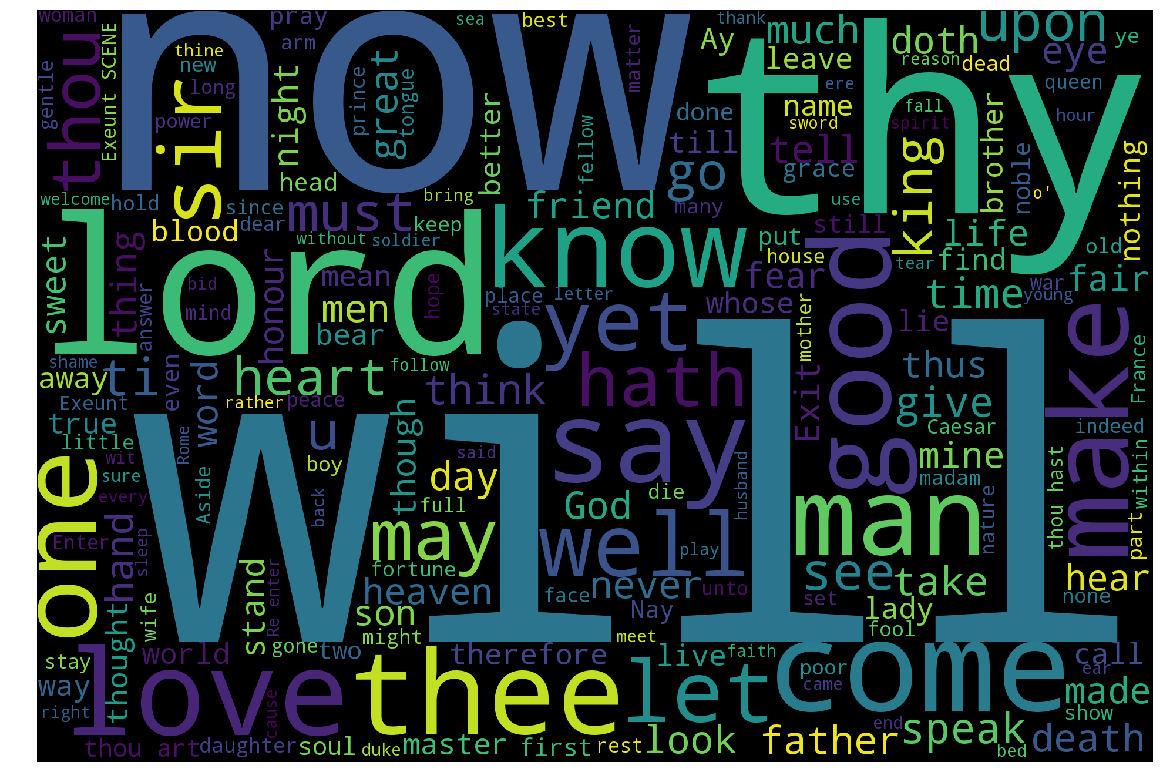

In [10]:
print('Total number of lines for training: {}'.format(len(textLines)))
# Most frequent words in the data set. Just because. Using a beautiful wordcloud
from wordcloud import WordCloud 
cloud = WordCloud(width=1900, height=1280).generate(' '.join(wordcld.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
allData.head()

In [11]:
chars = sorted(list(set(textLines)))
char_size = len(chars)
print('number of characters:', char_size)
print(chars)

number of characters: 77
['\n', ' ', '!', '$', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
char2id = dict((c, i) for i, c in enumerate(chars))
id2char = dict((i, c) for i, c in enumerate(chars))

In [13]:
#Given a probability of each character, return a likely character, one-hot encoded
def sample(prediction):
    r = random.uniform(0,1)
    s = 0
    char_id = len(prediction) - 1
    for i in range(len(prediction)):
        s += prediction[i]
        if s >= r:
            char_id = i
            break
    char_one_hot = np.zeros(shape=[char_size])
    char_one_hot[char_id] = 1.0
    return char_one_hot

In [21]:
len_per_section = 20
skip = 2

sections = []
next_chars = []
for i in range(0, len(lines) - len_per_section, skip):
    sections.append(textLines[i: i + len_per_section])
    next_chars.append(textLines[i + len_per_section])
    
#Vectorize input and output
X = np.zeros((len(sections), len_per_section, char_size))
y = np.zeros((len(sections), char_size))
for i, section in enumerate(sections):
    for j, char in enumerate(section):
        X[i, j, char2id[char]] = 1
    y[i, char2id[next_chars[i]]] = 1

In [22]:
batch_size = 256
max_steps = 7000
log_every = 3000
test_every = 6000
hidden_nodes = 1024
test_start = 'How art thou'
checkpoint_directory = 'ckpt'

#Create a checkpoint directory
if tf.gfile.Exists(checkpoint_directory):
    tf.gfile.DeleteRecursively(checkpoint_directory)
tf.gfile.MakeDirs(checkpoint_directory)

print('training data size:', len(X))
print('approximate steps per epoch:', int(len(X)/batch_size))

training data size: 55688
approximate steps per epoch: 217


In [23]:
graph = tf.Graph()
with graph.as_default():
    ###########
    #Prep
    ###########
    #Variables and placeholders
    global_step = tf.Variable(0)
    
    data = tf.placeholder(tf.float32, [batch_size, len_per_section, char_size])
    labels = tf.placeholder(tf.float32, [batch_size, char_size])
    
    #Prep LSTM Operation
    #Input gate: weights for input, weights for previous output, and bias
    w_ii = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_io = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_i = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Forget gate: weights for input, weights for previous output, and bias
    w_fi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_fo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_f = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Output gate: weights for input, weights for previous output, and bias
    w_oi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_oo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_o = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Memory cell: weights for input, weights for previous output, and bias
    w_ci = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_co = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_c = tf.Variable(tf.zeros([1, hidden_nodes]))
    #LCTM Cell
    def lstm(i, o, state):
        input_gate = tf.sigmoid(tf.matmul(i, w_ii) + tf.matmul(o, w_io) + b_i)
        forget_gate = tf.sigmoid(tf.matmul(i, w_fi) + tf.matmul(o, w_fo) + b_f)
        output_gate = tf.sigmoid(tf.matmul(i, w_oi) + tf.matmul(o, w_oo) + b_o)
        memory_cell = tf.sigmoid(tf.matmul(i, w_ci) + tf.matmul(o, w_co) + b_c)
        state = forget_gate * state + input_gate * memory_cell
        output = output_gate * tf.tanh(state)
        return output, state
    
    ###########
    #Operation
    ###########
    #LSTM
    output = tf.zeros([batch_size, hidden_nodes])
    state = tf.zeros([batch_size, hidden_nodes])

    for i in range(len_per_section):
        output, state = lstm(data[:, i, :], output, state)
        if i == 0:
            outputs_all_i = output
            labels_all_i = data[:, i+1, :]
        elif i != (len_per_section - 1):
            outputs_all_i = tf.concat(0, [outputs_all_i, output])
            labels_all_i = tf.concat(0, [labels_all_i, data[:, i+1, :]])
        else:
            outputs_all_i = tf.concat(0, [outputs_all_i, output])
            labels_all_i = tf.concat(0, [labels_all_i, labels])
        
    #Classifier
    w = tf.Variable(tf.truncated_normal([hidden_nodes, char_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([char_size]))
    logits = tf.matmul(outputs_all_i, w) + b
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels_all_i))

    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(10.).minimize(loss, global_step=global_step)
    
    ###########
    #Test
    ###########
    test_data = tf.placeholder(tf.float32, shape=[1, char_size])
    test_output = tf.Variable(tf.zeros([1, hidden_nodes]))
    test_state = tf.Variable(tf.zeros([1, hidden_nodes]))
    
    #Reset at the beginning of each test
    reset_test_state = tf.group(test_output.assign(tf.zeros([1, hidden_nodes])), 
                                test_state.assign(tf.zeros([1, hidden_nodes])))

    #LSTM
    test_output, test_state = lstm(test_data, test_output, test_state)
    test_prediction = tf.nn.softmax(tf.matmul(test_output, w) + b)

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [ ]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    offset = 0
    saver = tf.train.Saver()
    
    for step in range(max_steps):
        offset = offset % len(X)
        if offset <= (len(X) - batch_size):
            batch_data = X[offset: offset + batch_size]
            batch_labels = y[offset: offset + batch_size]
            offset += batch_size
        else:
            to_add = batch_size - (len(X) - offset)
            batch_data = np.concatenate((X[offset: len(X)], X[0: to_add]))
            batch_labels = np.concatenate((y[offset: len(X)], y[0: to_add]))
            offset = to_add
        _, training_loss = sess.run([optimizer, loss], feed_dict={data: batch_data, labels: batch_labels})
        
        if step % log_every == 0:
            print('training loss at step %d: %.2f (%s)' % (step, training_loss, datetime.datetime.now()))

            if step % test_every == 0:
                reset_test_state.run()
                test_generated = test_start
                
                for i in range(len(test_start) - 1):
                    test_X = np.zeros((1, char_size))
                    test_X[0, char2id[test_start[i]]] = 1.
                    _ = sess.run(test_prediction, feed_dict={test_data: test_X})
                
                test_X = np.zeros((1, char_size))
                test_X[0, char2id[test_start[-1]]] = 1.
                
                for i in range(500):
                    prediction = test_prediction.eval({test_data: test_X})[0]
                    next_char_one_hot = sample(prediction)
                    next_char = id2char[np.argmax(next_char_one_hot)]
                    test_generated += next_char
                    test_X = next_char_one_hot.reshape((1, char_size))
                    
                print('=' * 80)
                print(test_generated)
                print('=' * 80)
                
                saver.save(sess, checkpoint_directory + '/model', global_step=step)